# Time series correlations
### with and without a lag

I'm going to see how well distributions across time agree with each other, in general, and then see whether the average correlation can be improved by a lag in either direction.


In [1]:
import os, csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
%matplotlib inline


In [2]:
relativepath = os.path.join('..', 'data', 'bio_logratios.csv')
bio = pd.read_csv(relativepath)

relativepath = os.path.join('..', 'data', 'fiction_logratios.csv')
fic = pd.read_csv(relativepath)

In [3]:
bio.head()

,thedate,had,said,was,wrote,life,father,made,went,took,...,lane,groaned,reticence,helmet,disadvantage,alighted,pet,oldest,was-scheduled,bestow
0,1780.0,-0.403224,-0.204987,-1.530657,-0.955293,-0.955293,-1.648440,-0.549828,-0.955293,-1.648440,...,0.143319,0.143319,0.143319,0.143319,0.143319,0.143319,0.143319,0.143319,0.143319,-0.549828
1,1781.0,-4.031563,0.285925,-2.016660,-2.658514,-1.793516,-0.630366,-1.965367,-1.505834,-1.218152,...,0.285925,0.285925,0.285925,0.285925,0.285925,0.285925,0.285925,0.285925,0.285925,0.285925
2,1782.0,-2.521740,0.043210,-2.036232,-0.649938,-1.055403,-1.055403,-2.036232,-1.055403,-1.055403,...,0.043210,0.043210,0.043210,0.043210,0.043210,0.043210,0.043210,0.043210,0.043210,0.043210
3,1783.0,-0.538762,0.319231,-0.482374,-1.188424,-1.145865,0.891017,-0.586249,0.242322,-0.013439,...,0.197870,0.197870,-0.495277,0.197870,0.197870,0.197870,0.197870,0.197870,0.197870,0.197870
4,1784.0,-2.270239,-1.368673,-1.581424,-1.642625,-1.902606,-1.429709,-1.598785,-2.511737,-1.661393,...,1.434688,1.434688,1.434688,1.434688,1.434688,1.434688,1.434688,1.434688,1.434688,0.336075


In [4]:
fic.head()

,thedate,said,had,was,eyes,looked,face,head,thought,asked,...,was-mixed,trace,stroking,objection,sabre,shower,sphere,hovering,masters,scattered
0,1780.0,-2.631390,-1.191334,-0.980709,-0.338855,-1.332107,-1.619789,-0.387645,0.459653,-1.214324,...,0.171971,0.171971,0.171971,0.171971,0.171971,0.171971,0.171971,0.171971,0.171971,0.171971
1,1781.0,-0.104183,-0.024141,-0.215409,0.894345,0.994429,-0.391865,0.588964,-0.877373,-0.797331,...,-0.104183,-0.104183,-0.104183,-0.104183,-0.104183,-0.104183,-0.104183,-0.104183,-0.104183,0.588964
2,1782.0,0.655911,-2.639926,-2.416782,-1.541313,0.761272,-0.779173,-0.625023,0.761272,1.166737,...,0.068124,0.068124,0.068124,0.068124,0.068124,0.068124,-0.625023,0.068124,0.068124,0.068124
3,1783.0,0.007782,-1.090830,-0.685365,0.007782,0.007782,0.007782,0.007782,-0.685365,0.007782,...,0.007782,0.007782,0.007782,0.007782,0.007782,0.007782,0.007782,0.007782,0.007782,0.007782
4,1784.0,-0.232147,-0.958302,-0.845998,0.432082,-0.712467,-1.656929,-0.190592,-0.507023,-0.947781,...,0.540296,0.540296,0.540296,1.233443,0.540296,0.540296,0.540296,0.540296,0.540296,0.540296


### Getting shared words

This code is basically stolen from Natalie.

In [5]:
bio_list = list(bio.columns.values)
fic_list = list(fic.columns.values)
shared_words = set(fic_list).intersection(set(bio_list))
shared_list = list(shared_words)
shared_list.pop(shared_list.index('thedate'))
fic_subset = fic[list(shared_list)]
bio_subset = bio[list(shared_list)]
print(fic_subset.shape)
print(bio_subset.shape)

(228, 4142)
(228, 4142)


In [6]:
word = 'hair'
r, p = pearsonr(fic_subset[word], bio_subset[word])
print(r, p)

0.278658669892 1.96001307604e-05


### Fisher's transform: averaging correlation coefficients

Defining a function to average r values.

In [28]:
def fisher_average(listofrvals):
    zscores = (np.arctanh(listofrvals))
    avg_z = sum(zscores) / len(zscores)
    transformed_r = np.tanh(avg_z)
    naive_r = sum(listofrvals) / len(listofrvals)
    
    return transformed_r, naive_r
    

### Measuring correlations without lag

An initial pass on calculating the correlation between two time series for each word:

**a)** genderedness-across-time in fiction and

**b)** genderedness-across-time in biography.

In [30]:
# Let's calculate correlations for each word across time

r_list = []
significant = 0

for w in shared_list:
    r, p = pearsonr(fic_subset[w], bio_subset[w])
    r_list.append(r)
    if (p / 2) < 0.05 and r > 0:
        significant += 1
    # The scipy function reports a two-tailed p-value
    # But we are clearly expecting positive correlations
    # and wouldn't consider negative ones as significant.
    # So I'm dividing p by 2 to convert to a one-tailed test.

print(significant)
print(fisher_average(r_list))

1308
(0.072076481808508799, 0.069969882436332426)


### Correlations with lag

Let's try sliding the time series by as much as 12 years either way. Of course, when we shift the time series relative to each other, the area of overlap in the middle will be *smaller* than the original timeline. In order to make an apples-to-apples comparison between time series of the same length, we'll need to cut something off the end of the time series even when we're just shifting them zero, or one years, relative to each other. In other words, if we want to compare the central overlap between two time series shifted 12 years relative to each other, we need to compare it to an unshifted pairing *that has twelve years taken off either end.*

Trimming the ends is potentially a complicating factor, since the ends of the timeline might be inherently less (or more) likely to correlate. We can partly address this by running the shift comparison several times, with a different "ceiling" on the shift each time. I.e., the first time we'll shift a maximum of two years and That way we can see which differences are due to considering a smaller timeline, and which differences are due to the shift itself.


2
3
4
5
6
7
8
9
10
11
12
13
14


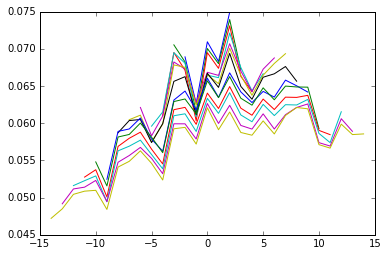

In [13]:
def shifted_correlation(vectora, vectorb, shift_ceiling, shift):
    
    assert len(vectora) == len(vectorb)
    maxlen = len(vectora)
    floor = shift_ceiling
    ceiling = maxlen - shift_ceiling
    floorb = floor + shift
    ceilingb = ceiling + shift
    slicea = vectora[floor : ceiling]
    sliceb = vectorb[floorb : ceilingb]
    return pearsonr(slicea, sliceb)

the_correlations = dict()
# we're going to create a different dictionary entry
# for each "shift-ceiling"

for shift_ceiling in range(2, 15):
    print(shift_ceiling)
    
    shifts = []
    correlations = []
    
    for shift in range(-shift_ceiling, shift_ceiling + 1):
        temp_r = []
        significant = 0

        for w in shared_list:
            r, p = shifted_correlation(fic_subset[w], bio_subset[w], shift_ceiling, shift)
            temp_r.append(r)
            if (p / 2) < 0.05 and r > 0:
                significant += 1

        true_avg, naive_avg = fisher_average(temp_r)
        shifts.append(shift)
        correlations.append(true_avg)
    
    the_correlations[shift_ceiling] = list(zip(shifts, correlations))
    
    # we save a list of tuples where x[0] = shift and x[1] = avg corr

for sc in range(2,15):
    x, y = zip(*the_correlations[sc])
    plt.plot(x, y)

plt.show()

#### Interpretation.

I'm not exactly sure what to make of those results. I think the peak correlation is (usually) around 0, which suggests that lag is not helping.

On the other hand, there's a pretty clear asymmetry in the curve. Correlations are generally lower when biography is shifted *back* relative to fiction than when it's shifted *forward.* I'm not sure I should make anything of that, but it's intriguing enough to make me want to keep trying this with different slices of the timeline.

That will help rule out the possibility that this is due to something odd about the ends of the timeline.

Let's try five different 100-year periods. 1800-1900, 1820-1920, and so on. In each case, we'll try a 16-year lag.


20
40
60
80


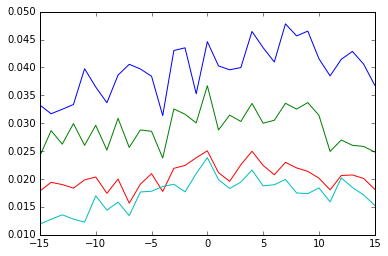

In [23]:
import math

def correlate_arbitrary_slice(vectora, vectorb, shift, absolute_floor):
    
    assert len(vectora) == len(vectorb)
    maxlen = len(vectora)
    floor = absolute_floor
    ceiling = absolute_floor + 100
    floorb = floor + shift
    ceilingb = ceiling + shift
    slicea = vectora[floor : ceiling]
    sliceb = vectorb[floorb : ceilingb]
    
    return pearsonr(slicea, sliceb)

the_correlations = dict()
# we're going to create a different dictionary entry
# for each "shift-ceiling"

for absolute_floor in range(20, 100, 20):
    print(absolute_floor)
    shift_ceiling = 15
    shifts = []
    correlations = []
    
    for shift in range(-shift_ceiling, shift_ceiling + 1):
        temp_r = []
        significant = 0

        for w in shared_list:
            r, p = correlate_arbitrary_slice(fic_subset[w], bio_subset[w], shift, absolute_floor)
            if not math.isnan(r):
                temp_r.append(r)
            if (p / 2) < 0.05 and r > 0:
                significant += 1

        true_avg, naive_avg = fisher_average(temp_r)
        shifts.append(shift)
        correlations.append(true_avg)
    
    the_correlations[absolute_floor] = list(zip(shifts, correlations))
    
    # we save a list of tuples where x[0] = shift and x[1] = avg corr

for af in range(20, 100, 20):
    x, y = zip(*the_correlations[af])
    plt.plot(x, y)

plt.show()

### Okay, that's very telling.

If the code I wrote is running correctly, there are **big** differences in the average correlation across *different segments of the timeline.* We need to figure out why that would be true, first of all! But secondly, if that's true, it's really not going to work to compare shift-backward and shift-forward, because of course you'l get different correlations.


In [27]:
for af in range(20, 100, 20):
    x, y = zip(*the_correlations[af])
    meancorr = sum(y) / len(y)
    print("From " + str(1780 + af) + " to " + str(1780 + af + 100) + ": " + str(meancorr))

From 1800 to 1900: 0.0396202029474
From 1820 to 1920: 0.0291253579908
From 1840 to 1940: 0.0204673473452
From 1860 to 1960: 0.0173203057619


Okay, this could be caused by an error of some kind. But if it's not an error, it means biography and fiction are tracking each other less well as we move forward in time.

Worth keeping in mind that it could be caused by distribution of examples in the datasets being uneven across time, or gender differences in authorship, or the vocabulary being biased in some way across time.

### Calculating means

code stolen from Natalie

In [38]:
bio_mean = bio_subset.mean(axis=0).reset_index()
bio_mean.columns = ['word', 'bio_mean']
fic_mean = fic_subset.mean(axis=0).reset_index()
fic_mean.columns = ['word', 'fic_mean']
means_df = pd.DataFrame(bio_mean).merge(pd.DataFrame(fic_mean), on='word', how='inner')
means_df.head()

,word,bio_mean,fic_mean
0,was-heard,-0.294704,-0.184891
1,antagonist,-0.822483,-1.478821
2,was-received,-0.361099,-0.441861
3,actions,-0.366177,-0.132995
4,grandfather,-0.053731,-0.035905


In [40]:
means_df.sort_values(by='fic_mean', ascending=False).head(10)

,word,bio_mean,fic_mean
1103,ladyship,3.083261,3.287758
2911,husband,4.020786,3.287313
950,maid,2.721104,2.751196
544,girlhood,2.697225,2.598002
3353,woman,3.318362,2.511099
2884,there,2.411703,2.393847
1575,again,2.317613,2.290945
3715,up,2.488732,2.253010
149,down,2.042299,2.202666
79,beauty,2.667919,2.168133


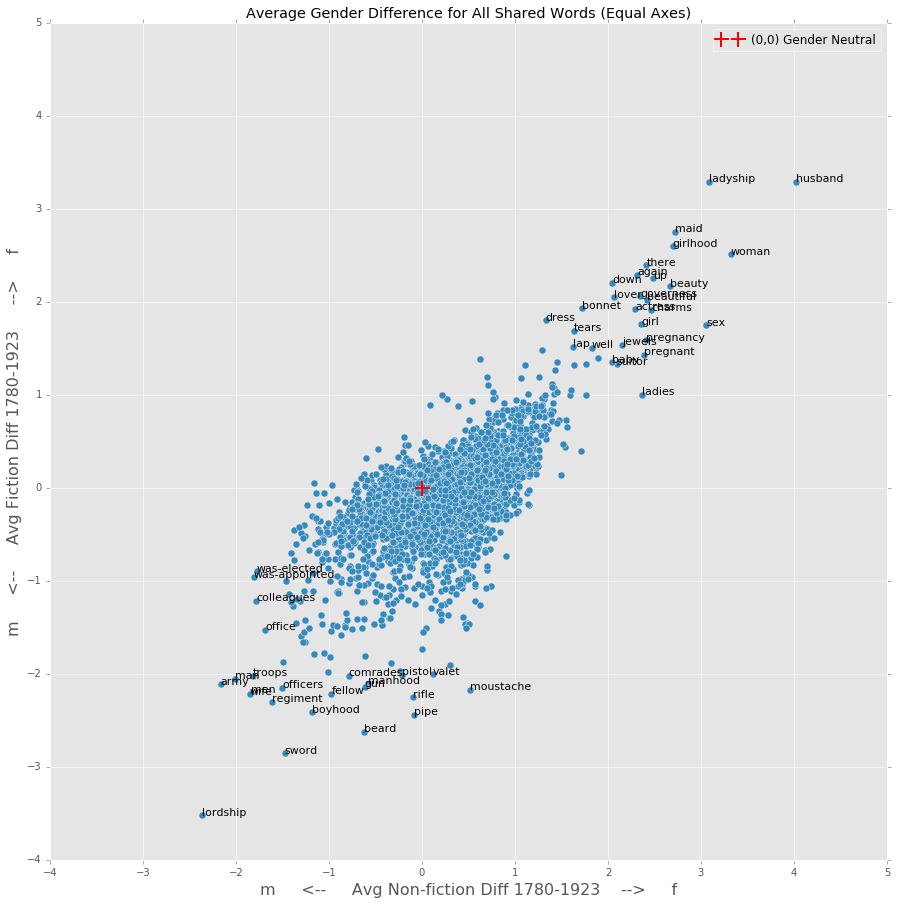

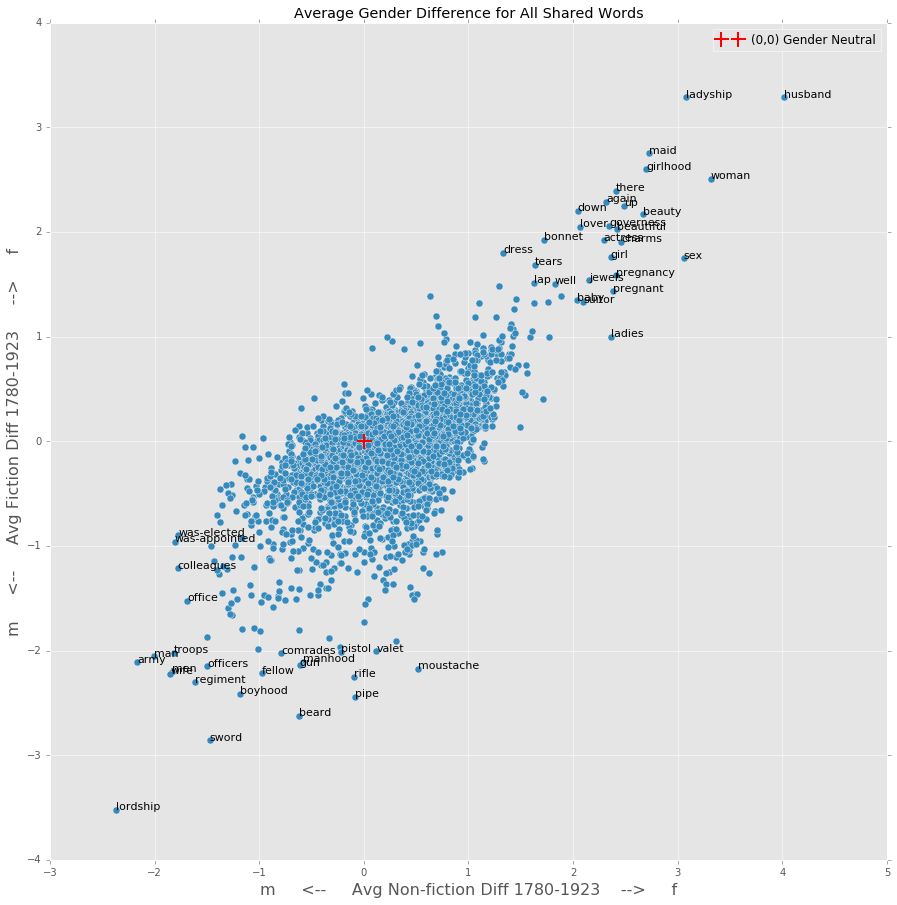

In [51]:
all_words = list(means_df.word.unique())
len(all_words)

def plot_diff_means(words, adjust=False, title=False, label_outliers=False, normalize_axes=False, save=False):
    df = means_df.loc[(means_df.word.isin(words)),:]
    ax0 = df.plot('bio_mean', 'fic_mean', kind='scatter', s=50, figsize=(15,15))
    ax0.plot(0, 0, 'r+', ms=15, mew=2, label='(0,0) Gender Neutral')
    
    texts = []
    for x, y, s in zip(df['bio_mean'], df['fic_mean'], df['word']):
        if label_outliers:
            if ((-1.5 < x < 2) == False) | ((-2 < y < 1.5) == False):
                texts.append((x, y, s))
    
    plt.legend(loc='best')
    plt.xlabel('m     <--     Avg Non-fiction Diff 1780-1923    -->     f', fontsize=16, )
    plt.ylabel('m     <--     Avg Fiction Diff 1780-1923     -->     f', fontsize=16)
    if title:
        plt.title(title)
    if normalize_axes:
        ylim = ax0.get_ylim()
        xlim = ax0.get_xlim()
        new_low = min(xlim[0], ylim[0])
        new_hi = max(xlim[1], ylim[1])
        plt.ylim(new_low, new_hi)
        plt.xlim(new_low, new_hi)
    
    if label_outliers:
        for x, y, label in texts:
            plt.annotate(label, xy=(x, y), size = 11)
    
    if save:
        if title:
            plt.savefig('./{}.png'.format(title))
        else:
            plt.savefig('./genderDiffMeans.png')
    plt.show()
    
plot_diff_means(all_words, adjust=True, title="Average Gender Difference for All Shared Words (Equal Axes)", label_outliers=True, normalize_axes=True, save=True)
plot_diff_means(all_words, adjust=True, title="Average Gender Difference for All Shared Words", label_outliers=True, normalize_axes=False, save = True)

In [47]:
pearsonr(means_df['bio_mean'], means_df['fic_mean'])

(0.63765533084185766, 0.0)